In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

import pandas as pd
pd.options.display.width = 500

n_bins_default = 10
num_poly_features = 1
slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue'}


In [3]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        df = cache_dict['df']
        p = list(cache_dict['parameter_names'])
        return df, p

In [4]:
rename_dict = {
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr',
    'waypoint_start_time': 'start_time',
}
robot_parameters = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
]
other_parameters = [
    'slam_node',
    'environment_name',
]
input_metrics = [
    'start_time',
    'tgs',
    'lvr',
]
output_metrics = [
    'norm_translation_error',
    'translation_error',
    'rotation_error',
    'trajectory_length',
]

df, params = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")

df = df[df.linear_angular_update == (0.5, 0.5)]
df = df[df.trajectory_length_trajectory_length > 1]

df.rename(columns=rename_dict, inplace=True)
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length

df = df[
    robot_parameters + 
    other_parameters + 
    input_metrics + 
    output_metrics
]

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

for c in robot_parameters + other_parameters:
    print("{:>30}".format(c), sorted(list(df[c].unique())))


          laser_scan_max_range [3.5, 8.0, 15.0, 30.0]
            laser_scan_fov_deg [90, 180, 270, 359]
                          beta [0.0, 2.0]
                     slam_node ['gmapping', 'slam_toolbox']
              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']


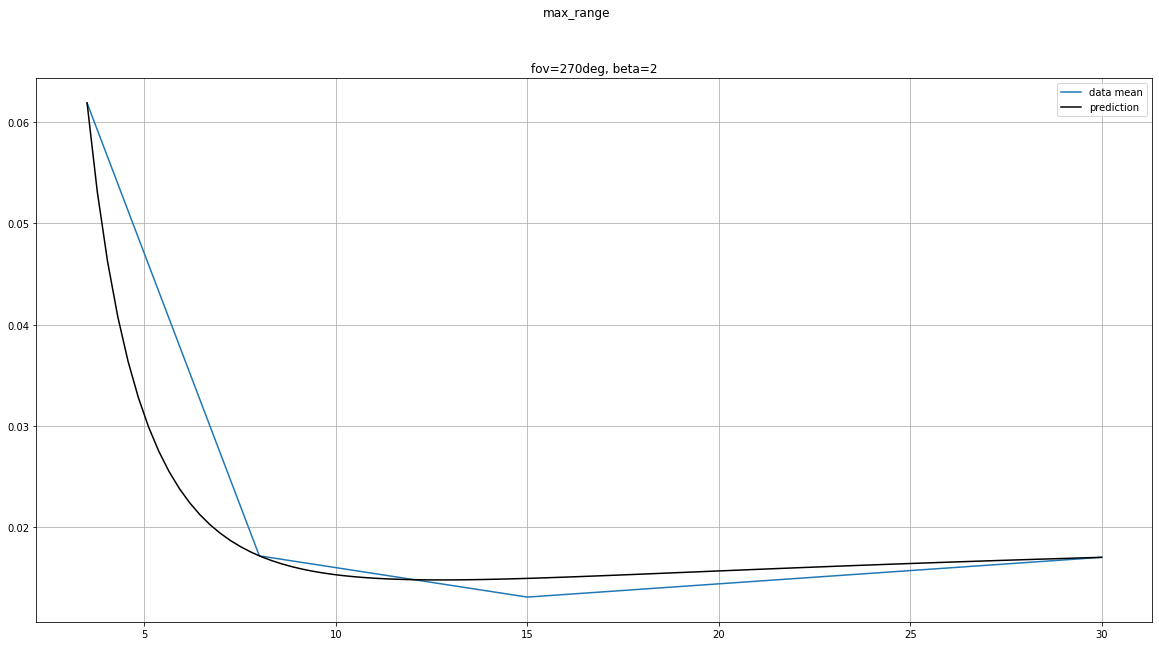

In [5]:
num_polynomial_features = 2

fov = 270
beta = 2
df_model = df[
    (df.beta == beta) &
    (df.laser_scan_fov_deg == fov)
]

df_by_params = df[
    (df.slam_node == "slam_toolbox") &
    (df.beta == beta) &
    (df.laser_scan_fov_deg == fov)
].groupby(['laser_scan_max_range']).mean()

X = np.array(list(df_by_params.norm_translation_error.index))[:, np.newaxis]
X = 1/X

y = df_by_params.norm_translation_error.values

model_gm = make_pipeline(PolynomialFeatures(num_polynomial_features), HuberRegressor())
model_gm.fit(X, y);

df_gm_params = df_model[
    (df_model.slam_node == 'slam_toolbox')
]

df_gm_params_mean = df_gm_params.groupby(df_gm_params.laser_scan_max_range).mean()
x_mean = df_gm_params_mean.index
y_mean = df_gm_params_mean.norm_translation_error
plt.plot(x_mean, y_mean, label="data mean")

x_plot = np.linspace(min(mrs), max(mrs), 100)
x_pred = np.array([[1/mr] for mr in x_plot])
y_pred = model_gm.predict(x_pred)
plt.plot(x_plot, y_pred, color="black", label="prediction")

plt.title(f"fov={fov}deg, beta={beta}")
plt.grid(True)
plt.legend()
plt.suptitle("max_range")
plt.show()

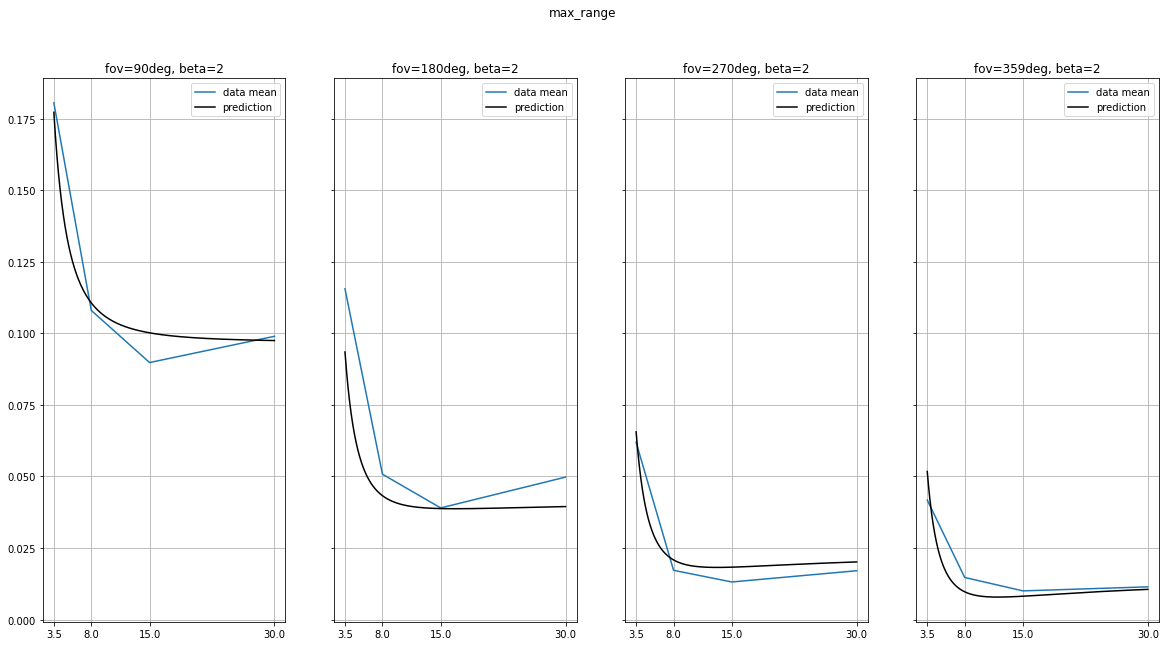

In [6]:
num_polynomial_features = 2

beta = 2
df_model = df[
    (df.beta == beta)
]

# df_gm = df_model[(df_model.slam_node == "slam_toolbox")]
# X_gm_all = df_gm[robot_parameters].values
# X_gm_all[:, 0] = 1/X_gm_all[:, 0]
# X_gm_all[:, 1] = 1/X_gm_all[:, 1]

# y_gm_all = df_gm.norm_translation_error.values

# model_gm = make_pipeline(PolynomialFeatures(num_polynomial_features), HuberRegressor())
# model_gm.fit(X_gm_all, y_gm_all);

df_by_params = df[
    (df.slam_node == "slam_toolbox") &
    (df.beta == beta)
].groupby(['laser_scan_max_range', 'laser_scan_fov_deg']).mean()

X = np.array(list(df_by_params.norm_translation_error.index))
X[:, 0] = 1/X[:, 0]
X[:, 1] = 1/X[:, 1]

y = df_by_params.norm_translation_error.values

model_gm = make_pipeline(PolynomialFeatures(num_polynomial_features), HuberRegressor())
model_gm.fit(X, y);

fig, axs = plt.subplots(1, len(fovs))
for j, fov in enumerate(fovs):

    df_gm_params = df_model[
        (df_model.slam_node == 'slam_toolbox') &
        (df_model.laser_scan_fov_deg == fov) &
        (df_model.beta == beta)
    ]

    df_gm_params_mean = df_gm_params.groupby(df_gm_params.laser_scan_max_range).mean()
    x_mean = df_gm_params_mean.index
    y_mean = df_gm_params_mean.norm_translation_error
    axs[j].plot(x_mean, y_mean, label="data mean")

    x_plot = np.linspace(min(mrs), max(mrs), 1000)
    x_pred = np.array([[1/mr, 1/fov] for mr in x_plot])
    y_pred = model_gm.predict(x_pred)
    axs[j].plot(x_plot, y_pred, color="black", label="prediction")

    axs[j].set_title(f"fov={fov}deg, beta={beta}")
    axs[j].sharex(axs[0])
    axs[j].sharey(axs[0])
    axs[j].grid(True)
    axs[j].label_outer()
    axs[j].legend()
plt.suptitle("max_range")
plt.xticks(x_mean)
plt.show()


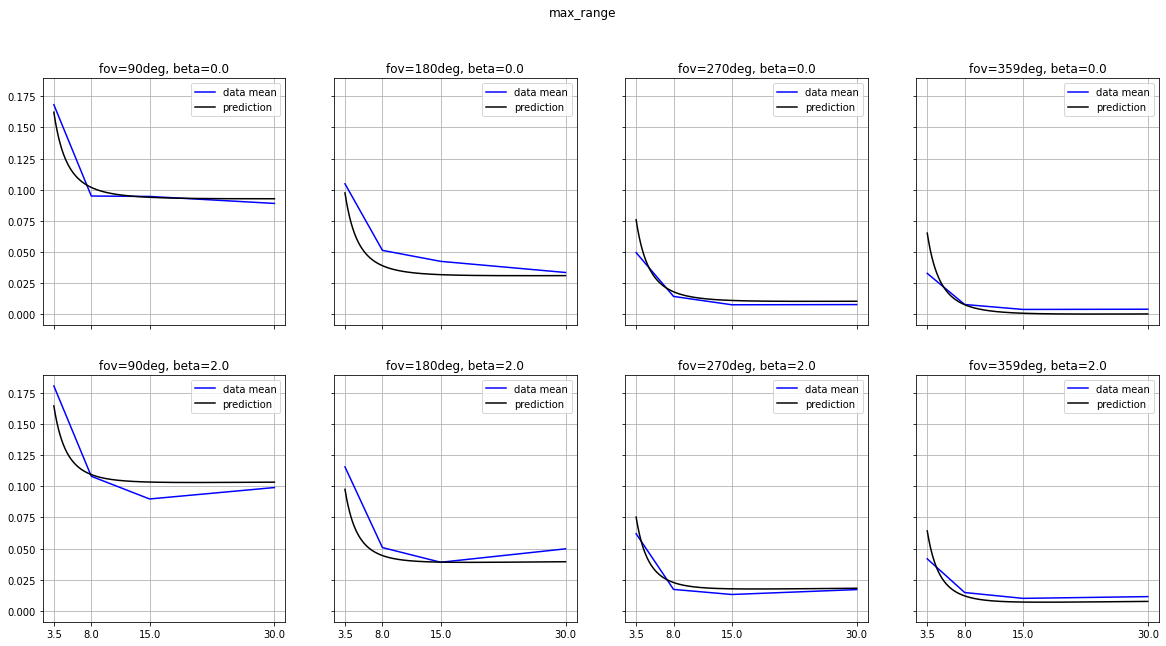

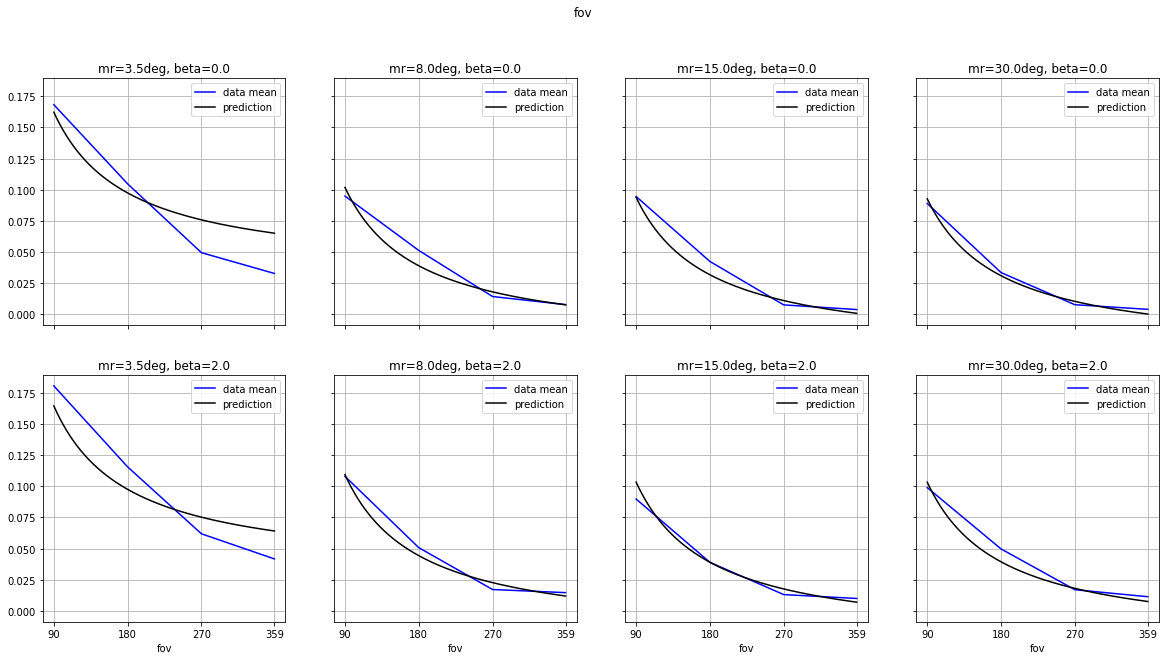

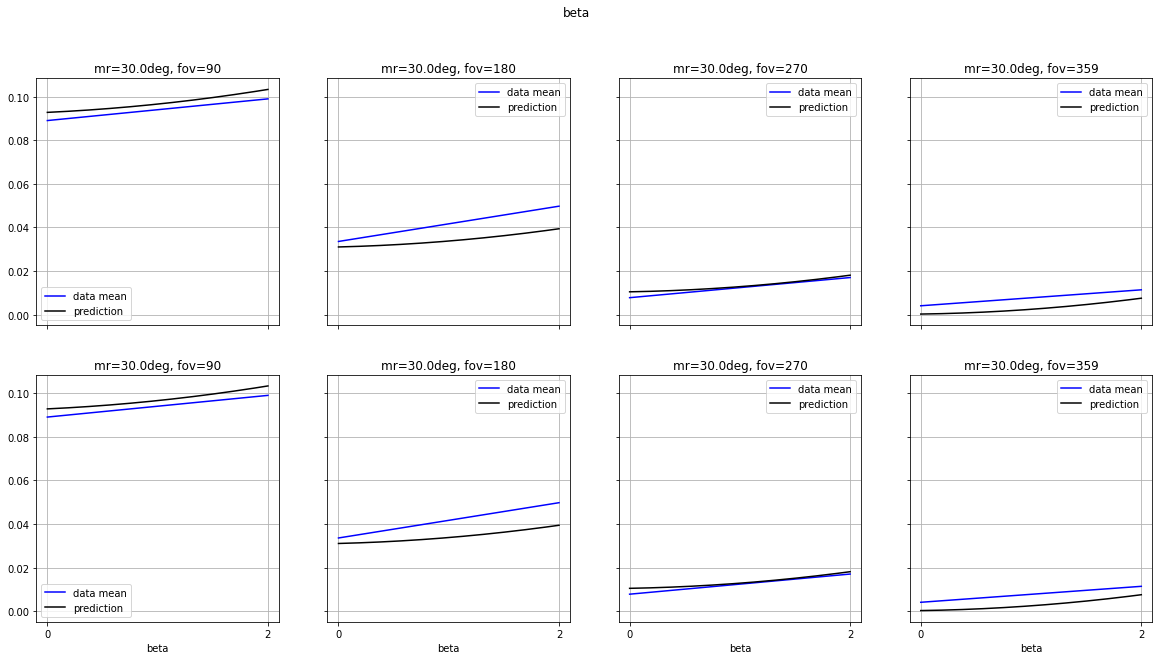

In [7]:
num_polynomial_features = 2

df_by_params = df[df.slam_node == "slam_toolbox"].groupby(robot_parameters).mean()

X = np.array(list(df_by_params.norm_translation_error.index))
X[:, 0] = 1/X[:, 0]
X[:, 1] = 1/X[:, 1]

y = df_by_params.norm_translation_error.values

model_gm = make_pipeline(PolynomialFeatures(num_polynomial_features), HuberRegressor())
model_gm.fit(X, y);

fig, axs = plt.subplots(len(betas), len(fovs))
for i, beta in enumerate(betas):
    for j, fov in enumerate(fovs):

        df_gm_params = df[
            (df.slam_node == 'slam_toolbox') &
            (df.laser_scan_fov_deg == fov) &
            (df.beta == beta)
        ]

        df_gm_params_mean = df_gm_params.groupby(df_gm_params.laser_scan_max_range).mean()
        x_mean = df_gm_params_mean.index
        y_mean = df_gm_params_mean.norm_translation_error
        axs[i, j].plot(x_mean, y_mean, label="data mean", color=slam_node_colors['slam_toolbox'])

        x_plot = np.linspace(min(mrs), max(mrs), 1000)
        x_pred = np.array([[1/mr, 1/fov, beta] for mr in x_plot])
        y_pred = model_gm.predict(x_pred)
        axs[i, j].plot(x_plot, y_pred, color="black", label="prediction")

        axs[i, j].set_title(f"fov={fov}deg, beta={beta}")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)
        axs[i, j].label_outer()
        axs[i, j].legend()
plt.suptitle("max_range")
plt.xticks(x_mean)
plt.show()

fig, axs = plt.subplots(len(betas), len(mrs))
for i, beta in enumerate(betas):
    for j, mr in enumerate(mrs):

        df_gm_params = df[
            (df.slam_node == 'slam_toolbox') &
            (df.laser_scan_max_range == mr) &
            (df.beta == beta)
        ]

        df_gm_params_mean = df_gm_params.groupby(df_gm_params.laser_scan_fov_deg).mean()
        x_mean = df_gm_params_mean.index
        y_mean = df_gm_params_mean.norm_translation_error
        axs[i, j].plot(x_mean, y_mean, label="data mean", color=slam_node_colors['slam_toolbox'])

        x_plot = np.linspace(min(fovs), max(fovs), 1000)
        x_pred = np.array([[1/mr, 1/fov, beta] for fov in x_plot])
        y_pred = model_gm.predict(x_pred)
        axs[i, j].plot(x_plot, y_pred, color="black", label="prediction")

        axs[i, j].set_title(f"mr={mr}deg, beta={beta}")
        axs[i, j].set(xlabel="fov")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)
        axs[i, j].label_outer()
        axs[i, j].legend()
plt.suptitle("fov")
plt.xticks(x_mean)
plt.show()

fig, axs = plt.subplots(len(betas), len(fovs))
for i, beta in enumerate(betas):
    for j, fov in enumerate(fovs):

        df_gm_params = df[
            (df.slam_node == 'slam_toolbox') &
            (df.laser_scan_max_range == mr) &
            (df.laser_scan_fov_deg == fov)
        ]

        df_gm_params_mean = df_gm_params.groupby(df_gm_params.beta).mean()
        x_mean = df_gm_params_mean.index
        y_mean = df_gm_params_mean.norm_translation_error
        axs[i, j].plot(x_mean, y_mean, label="data mean", color=slam_node_colors['slam_toolbox'])

        x_plot = np.linspace(min(betas), max(betas), 1000)
        x_pred = np.array([[1/mr, 1/fov, beta] for beta in x_plot])
        y_pred = model_gm.predict(x_pred)
        axs[i, j].plot(x_plot, y_pred, color="black", label="prediction")

        axs[i, j].set_title(f"mr={mr}deg, fov={fov}")
        axs[i, j].set(xlabel="beta")
        axs[i, j].sharex(axs[0, 0])
        axs[i, j].sharey(axs[0, 0])
        axs[i, j].grid(True)
        axs[i, j].label_outer()
        axs[i, j].legend()
plt.suptitle("beta")
plt.xticks(x_mean)
plt.show()